In [1243]:
import pandas as pd
chunk_size = 50000
data_chunk = pd.read_csv('training_dataset.csv', chunksize=chunk_size)

df = next(data_chunk)
df.head()

,ID,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,e624ebae-2d2f-41c1-b30f-ca222e1137f0,2,2024-10-09 20:37:37,2024-10-09 21:12:53,1.0,4.16,1.0,N,144,142,...,31.0,1.0,0.5,6.0,0.0,1.0,42.0,2.5,0.0,2116.0
1,b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5,2,2024-06-21 23:04:57,2024-06-21 23:14:06,1.0,1.03,1.0,N,144,79,...,10.0,1.0,0.5,2.0,0.0,1.0,17.0,2.5,0.0,549.0
2,65c77a1f-7c83-4044-99fb-5d61fed94ca9,2,2024-11-23 13:23:13,2024-11-23 13:27:26,2.0,0.62,1.0,N,230,186,...,-5.8,0.0,-0.5,0.0,0.0,-1.0,-9.8,-2.5,0.0,253.0
3,9b353c17-61a5-4bbd-a44c-ecbb381f62cf,2,2024-07-12 21:54:58,2024-07-12 22:07:47,1.0,1.41,1.0,N,113,4,...,12.1,1.0,0.5,2.0,0.0,1.0,19.1,2.5,0.0,769.0
4,b61489e1-e755-4ed9-9550-a8e5086eea2b,2,2024-04-24 11:56:39,2024-04-24 12:15:09,1.0,2.06,1.0,N,161,237,...,17.0,0.0,0.5,4.2,0.0,1.0,25.2,2.5,0.0,1110.0


In [1244]:

# Helper to print with prettier colors
class c:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [1245]:
nan_values_per_feature = df.isnull().sum()
nan_total = sum(list(df.isnull().sum()))
# Count number of rows that contain at least one NaN
rows_with_nan = df.isnull().any(axis=1).sum()

print(f"The dataset length: \t\t{c.BLUE}{len(df)}{c.END}")
print(f"Total number of missing values: {c.BOLD}{nan_total}{c.END}\n")
print(f"Total number of rows with missing values: {rows_with_nan}\n")

print(f"{c.BOLD}Printing how many entries in each column contain no NaN values{c.END}:")
df.info()


The dataset length: 		50000
Total number of missing values: 24010

Total number of rows with missing values: 4802

Printing how many entries in each column contain no NaN values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     50000 non-null  object 
 1   vendorid               50000 non-null  int64  
 2   tpep_pickup_datetime   50000 non-null  object 
 3   tpep_dropoff_datetime  50000 non-null  object 
 4   passenger_count        45198 non-null  float64
 5   trip_distance          50000 non-null  float64
 6   ratecodeid             45198 non-null  float64
 7   store_and_fwd_flag     45198 non-null  object 
 8   pulocationid           50000 non-null  int64  
 9   dolocationid           50000 non-null  int64  
 10  payment_type           50000 non-null  int64  
 11  fare_amount            50000 no

In [1246]:
df.dropna(inplace=True)

In [1247]:

column_names = ["ID", "vendorid","tpep_pickup_datetime", "tpep_dropoff_datetime","passenger_count", "p_distance",
                "ratecodeid","store_and_fwd_flag","pulocationid","dolocationid","payment_type","fare_amount",
                "extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","airport_fee","duration"]                 
            
df.columns = column_names
df.head()

print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()
    

List all attributes in the dataset and count how many entries of each kind

ID:
ID
1017f71f-7657-45b4-a855-85112de95204    1
e624ebae-2d2f-41c1-b30f-ca222e1137f0    1
b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5    1
65c77a1f-7c83-4044-99fb-5d61fed94ca9    1
9b353c17-61a5-4bbd-a44c-ecbb381f62cf    1
                                       ..
e95459bb-314e-47f7-a75c-ef4f6b824846    1
66764de3-04ed-4d1f-a4e0-7dab259fff24    1
eef10650-7419-4cfe-ae3c-de556e4f807c    1
d6b0636f-2788-4adf-bd8b-a54a0c7c86bc    1
3a8fb403-5371-4f9f-b9df-2a658ccfc763    1
Name: count, Length: 45198, dtype: int64

vendorid:
vendorid
2    34274
1    10924
Name: count, dtype: int64

tpep_pickup_datetime:
tpep_pickup_datetime
2024-09-19 17:51:23    2
2024-11-10 07:42:40    2
2024-09-15 10:12:53    2
2024-09-27 17:07:53    2
2024-03-13 09:38:28    2
                      ..
2024-11-07 18:05:19    1
2024-01-24 15:08:45    1
2024-10-17 15:52:41    1
2024-09-25 13:13:34    1
2024-02-10 11:43:47    1
Name: count, Length: 45161,

In [1248]:
print("List all attributes in the dataset and count how many entries of each kind\n")
for col in column_names:
    print(f"{c.BOLD}{col}:{c.END}")
    print(f"{df[col].value_counts()}")
    print()

List all attributes in the dataset and count how many entries of each kind

ID:
ID
1017f71f-7657-45b4-a855-85112de95204    1
e624ebae-2d2f-41c1-b30f-ca222e1137f0    1
b8ee7f2b-74da-4c5a-b959-eb93c8f18ce5    1
65c77a1f-7c83-4044-99fb-5d61fed94ca9    1
9b353c17-61a5-4bbd-a44c-ecbb381f62cf    1
                                       ..
e95459bb-314e-47f7-a75c-ef4f6b824846    1
66764de3-04ed-4d1f-a4e0-7dab259fff24    1
eef10650-7419-4cfe-ae3c-de556e4f807c    1
d6b0636f-2788-4adf-bd8b-a54a0c7c86bc    1
3a8fb403-5371-4f9f-b9df-2a658ccfc763    1
Name: count, Length: 45198, dtype: int64

vendorid:
vendorid
2    34274
1    10924
Name: count, dtype: int64

tpep_pickup_datetime:
tpep_pickup_datetime
2024-09-19 17:51:23    2
2024-11-10 07:42:40    2
2024-09-15 10:12:53    2
2024-09-27 17:07:53    2
2024-03-13 09:38:28    2
                      ..
2024-11-07 18:05:19    1
2024-01-24 15:08:45    1
2024-10-17 15:52:41    1
2024-09-25 13:13:34    1
2024-02-10 11:43:47    1
Name: count, Length: 45161,

In [1249]:
df = df.drop(columns=["ID"], axis=1)

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['tpep_pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['tpep_pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['tpep_pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['tpep_pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['tpep_pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['tpep_pickup_second'] = df['tpep_pickup_datetime'].dt.second

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df['tpep_dropoff_year'] = df['tpep_dropoff_datetime'].dt.year
df['tpep_dropoff_month'] = df['tpep_dropoff_datetime'].dt.month
df['tpep_dropoff_day'] = df['tpep_dropoff_datetime'].dt.day
df['tpep_dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

df['tpep_dropoff_minute'] = df['tpep_dropoff_datetime'].dt.minute
df['tpep_dropoff_second'] = df['tpep_dropoff_datetime'].dt.second


# Optionally drop the original datetime column
df = df.drop(columns=['tpep_pickup_datetime'], axis=1)
df = df.drop(columns=['tpep_dropoff_datetime'], axis=1)

# df = df.drop(columns=['tpep_pickup_month'], axis=1)
# df = df.drop(columns=['tpep_dropoff_month'], axis=1)


In [1251]:
mapping = {'N': 0, 'Y': 1}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(mapping)
print(df.head())


   vendorid  passenger_count  p_distance  ratecodeid  store_and_fwd_flag  \
0         2              1.0        4.16         1.0                   0   
1         2              1.0        1.03         1.0                   0   
2         2              2.0        0.62         1.0                   0   
3         2              1.0        1.41         1.0                   0   
4         2              1.0        2.06         1.0                   0   

   pulocationid  dolocationid  payment_type  fare_amount  extra  ...  \
0           144           142             1         31.0    1.0  ...   
1           144            79             1         10.0    1.0  ...   
2           230           186             2         -5.8    0.0  ...   
3           113             4             1         12.1    1.0  ...   
4           161           237             1         17.0    0.0  ...   

   tpep_pickup_month  tpep_pickup_day  tpep_pickup_hour  tpep_pickup_minute  \
0                 10           

In [1252]:
X_data = df.drop('duration', axis=1)
#  X_data = df[['p_distance', 'ratecodeid',
#        'fare_amount', 'mta_tax', 'tip_amount', 'tolls_amount',
#        'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'tpep_pickup_day',
#        'tpep_pickup_hour', 'tpep_dropoff_day', 'tpep_dropoff_hour']]
y_data = df['duration']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


# Tagit bort

Med alla features: 0.5860777766717762

Utan dessa features i ordning:
- Month: 0.130167677420308
- Second: 0.1300162809946408
- Min: 0.13021313440727722
- Airport fee: 0.12991431207270387
- Extra: 0.12940066092320301
- Store and fwd flag: 0.12940051435027156
- Year: 0.12922283998566508
- Vendorid: 0.12922082486054054
- Pulocation: 0.1292621789281002
- Passengercount: 0.129077988558293
- dolocation: 0.12871978287486396


In [1253]:
from sklearn.preprocessing import MinMaxScaler


#scaler = MinMaxScaler(feature_range=[0,1]).set_output(transform='pandas')
scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform='pandas')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


0.5860781846777556


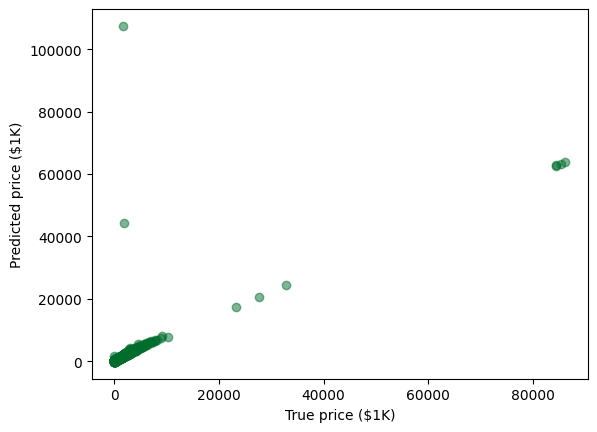

In [ ]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

def train(X, y):
    model = LinearRegression().fit(X, y)
    return model

reg = train(X_train, y_train)
    
print(reg.score(X_test, y_test))
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.5)

# Code provided by us to compare the generated predictions against the actual values
xlim = [0, 5]
ylim = [0, 5]
plt.plot(xlim, ylim, '--k')
plt.xlabel("True distance")
plt.ylabel("Predicted distance")
plt.show()

vendorid - Score: 11.29054
passenger_count - Score: 4.27555
p_distance - Score: 689.42435
ratecodeid - Score: 122.68739
store_and_fwd_flag - Score: -3.01089
pulocationid - Score: -1.81387
dolocationid - Score: -15.90572
payment_type - Score: 35.94943
fare_amount - Score: 5043.33420
extra - Score: 115.28277
mta_tax - Score: 316.59547
tip_amount - Score: 766.98628
tolls_amount - Score: 376.53060
improvement_surcharge - Score: -359.64967
total_amount - Score: -3751.45871
congestion_surcharge - Score: 68.04706
airport_fee - Score: -24.12062
tpep_pickup_month - Score: -10728928.47040
tpep_pickup_day - Score: -954086.81290
tpep_pickup_hour - Score: -30545.22093
tpep_pickup_minute - Score: -1309.70284
tpep_pickup_second - Score: -27.99301
tpep_dropoff_month - Score: 10728947.81467
tpep_dropoff_day - Score: 954089.71447
tpep_dropoff_hour - Score: 30561.05379
tpep_dropoff_minute - Score: 1313.36895
tpep_dropoff_second - Score: 24.80470


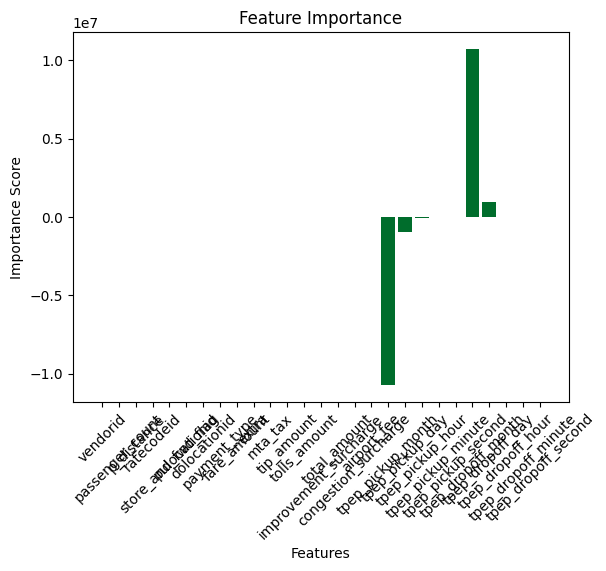

<Axes: >

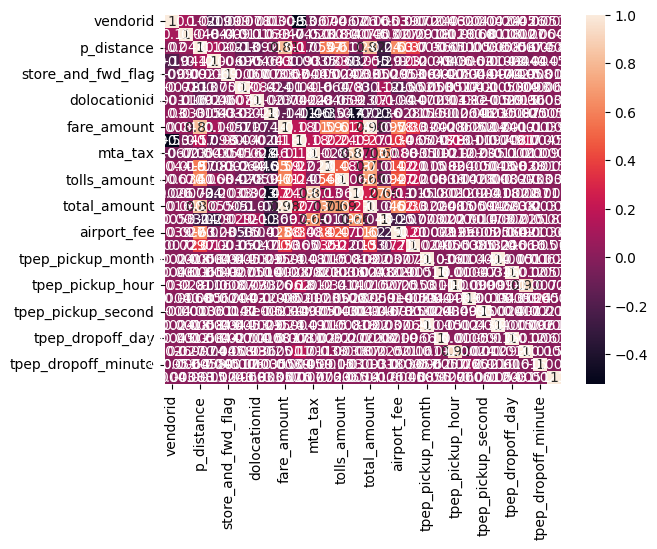

In [ ]:
import matplotlib.pyplot as plt

importance = reg.coef_
feature_names = reg.feature_names_in_

# Summarize feature importance
for i, v in enumerate(importance):
    print(f'{feature_names[i]} - Score: {v:.5f}')

# Plot feature importance
plt.bar(range(len(importance)), importance, tick_label=feature_names)
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Feature Importance")
plt.show()

# utan scaler
#195 0722.79732
# med scaler
#671 7302.92221
# med normalizer
# 5601743403.40787